In [ ]:
# conda install -c conda-forge notebook h5py pandas scikit-learn

In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer 
# viz 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
# feems 
from feems.utils import prepare_graph_inputs 
from feems import SpatialGraph, Viz 


In [22]:
metadata = pd.read_csv("Hoplo_metadata_FIXED.csv", index_col=0)
metadata = metadata.drop(["HOOC0024", "HOOC0039", "HOOC0047"])
metadata[["Lat", "Long"]].to_csv("Hoplo_latlong.coords", header=False, index=False, sep=" ")

coord = np.loadtxt("/home/iovercast/Hoplo_latlong.coords")
outer = np.loadtxt("/home/iovercast/Hoplo_feems.outer")
#grid_path = "/home/iovercast/grid_100.shp"
grid_path = "/home/iovercast/ng_triangle_res_09.shp"

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, ggrid=grid_path, translated=False, buffer=0, outer=outer)


In [3]:
# THIS TAKES FOREVER SO JUST RUN THE LOAD COMMAND IN THE NEXT CELL

# Path to the input phylip file
data = h5py.File("/home/iovercast/hoplo_assembly/Hoplo-PE_outfiles/Hoplonew.snps.hdf5")

raw_genotypes = np.apply_along_axis(np.sum, 2, data["genos"][:])

G = np.where(raw_genotypes <= 2, raw_genotypes, np.nan*raw_genotypes)
imp = SimpleImputer(missing_values=np.nan, strategy="mean") 
genotypes = imp.fit_transform(np.array(G).T)
np.save("Hoplo_feems_genotypes", genotypes)

In [3]:
genotypes = np.load("Hoplo_feems_genotypes.npy")

CPU times: user 2min 1s, sys: 835 ms, total: 2min 1s
Wall time: 2min 1s


/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


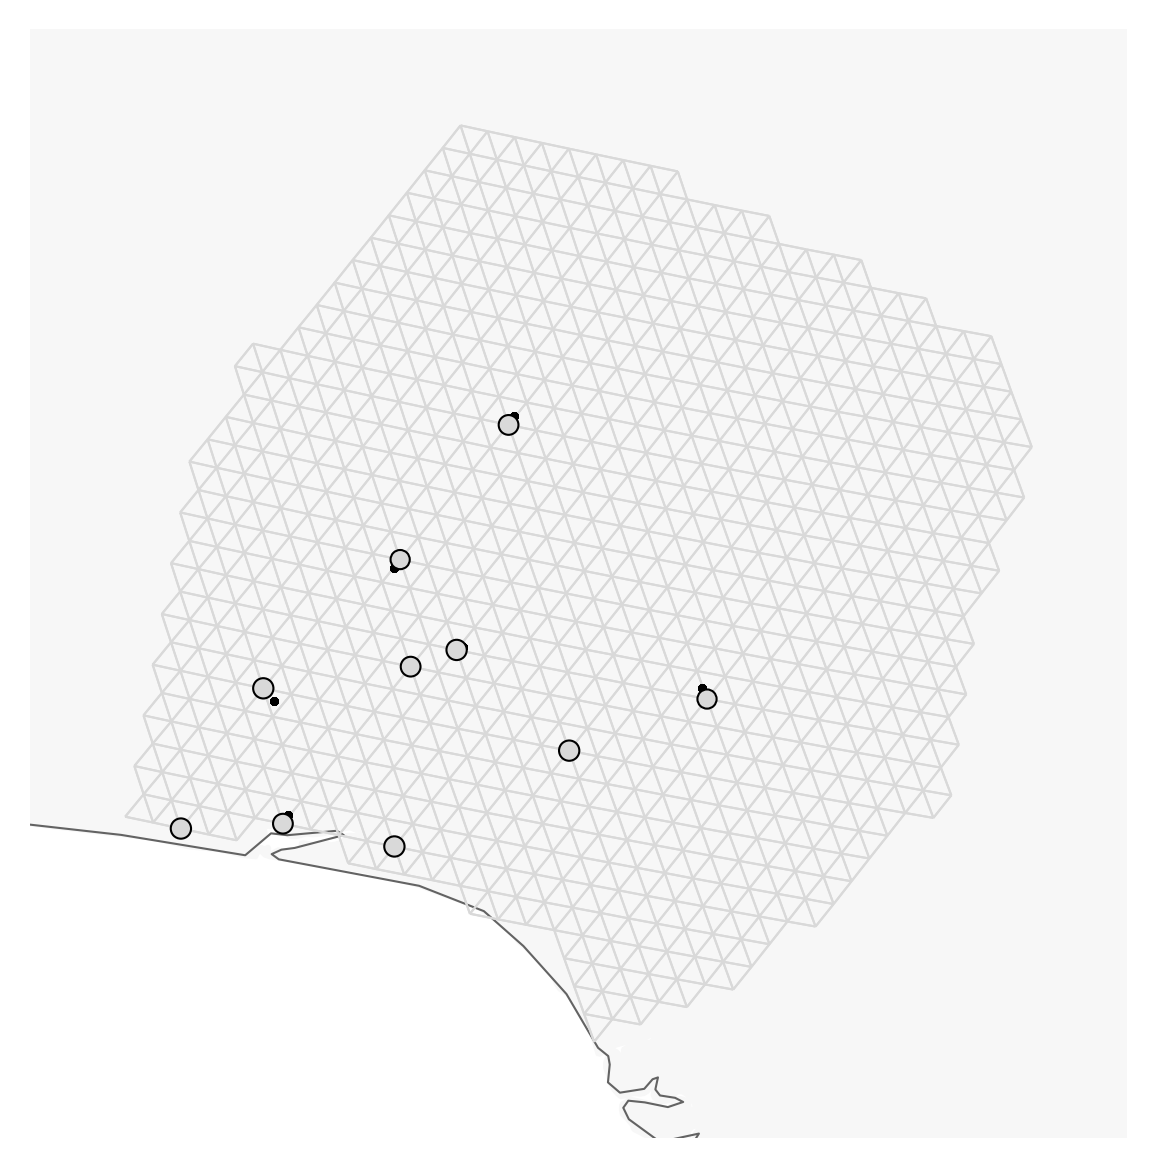

In [23]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=False)
projection = ccrs.EquidistantConic(central_longitude=23, central_latitude=8) 
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(1, 1, 1, projection=projection) 
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
    edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
    obs_node_size=7.5, sample_pt_color="black", 
    cbar_font_size=10) 
v.draw_map() 
v.draw_samples() 
v.draw_edges(use_weights=False) 
v.draw_obs_nodes(use_ids=False) 

In [26]:
%%time 
sp_graph.fit(lamb = 10.0) 

constant-w/variance fit, converged in 236 iterations, train_loss=-26310016.7895571
lambda=10.0000000, alpha=0.0155909, converged in 418 iterations, train_loss=-26778602.4758677
CPU times: user 17min 5s, sys: 1.93 s, total: 17min 7s
Wall time: 12.5 s


/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/iovercast/miniconda3/envs/feems/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


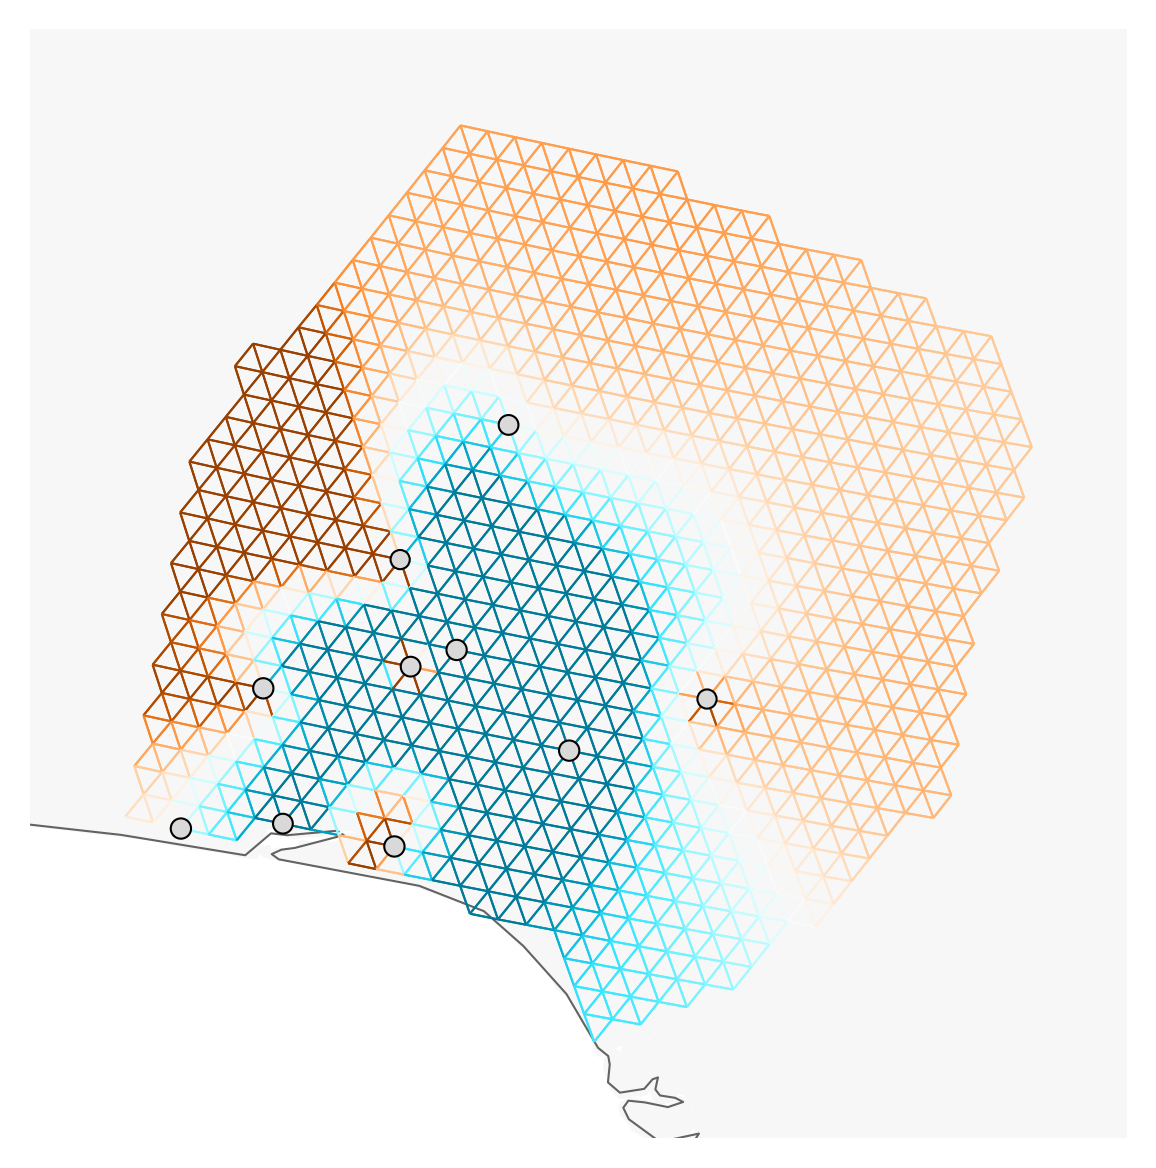

In [28]:
fig = plt.figure(dpi=300) 

ax = fig.add_subplot(1, 1, 1, projection=projection) 
v = Viz(ax, sp_graph, projection=projection, edge_width=0.5, 
    edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
    obs_node_size=7.5, sample_pt_color="black", 
    cbar_font_size=10, abs_max=0.5) 
v.draw_map() 
v.draw_edges(use_weights=True) 
v.draw_obs_nodes(use_ids=False) 
#v.draw_edge_colorbar()